<a href="https://colab.research.google.com/github/dev-SR/Deep-Learning/blob/main/04-pytorch-lighting-intro/pl_cv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q lightning datasets timm albumentations easydict

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 31.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 50.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 83.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 806.1/806.1 kB 58.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 776.9/776.9 kB 52.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 16.9 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.utils.data import (
    Dataset,
    DataLoader,
    Subset,
    SubsetRandomSampler,
)
from torch.optim.lr_scheduler import (
    CosineAnnealingLR,
    CosineAnnealingWarmRestarts,
    ReduceLROnPlateau,
    OneCycleLR,
)

import lightning as L
from lightning.pytorch.loggers import CSVLogger
from lightning.pytorch.callbacks.progress import TQDMProgressBar
from lightning.pytorch.callbacks import (
    LearningRateMonitor,
    ModelCheckpoint,
    BackboneFinetuning,
    EarlyStopping,
)

from torchmetrics import (
    Accuracy,
    F1Score,
)

from datasets import load_dataset

import timm

import albumentations as A
from albumentations.pytorch import ToTensorV2

import yaml
from easydict import EasyDict

# ignore warning
import warnings
warnings.filterwarnings("ignore")

In [3]:
# https://www.kaggle.com/code/ayuraj/use-pytorch-lightning-with-weights-and-biases#%F0%9F%94%A7-DataModule
# https://colab.research.google.com/github/wandb/examples/blob/master/colabs/pytorch-lightning/Supercharge_your_Training_with_Pytorch_Lightning_and_Weights_and_Biases.ipynb#scrollTo=TNAWmQAJgfb0
# https://colab.research.google.com/github/PytorchLightning/lightning-tutorials/blob/publication/.notebooks/lightning_examples/cifar10-baseline.ipynb#scrollTo=c16c73b7
# https://www.kaggle.com/code/egortrushin/gr-icrgw-training-with-4-folds?scriptVersionId=134148499
# https://www.kaggle.com/code/leonweninger/clean-pytorch-lightning-dnn-lb-0-144

In [4]:
# import shutil
# shutil.rmtree("/content/lightning_logs")

In [5]:
%%writefile config.yaml

data_path: "data"
output_dir: "models"

seed: &seed 42
max_epoch: &epoch 10
min_lr: &eta_min 0.000001
progress_bar_refresh_rate: 1

image:
    shape: [3,32,32]
    size: 32
    hw:
        height: 32
        width: 32

dl_train:
    batch_size: 128
    num_workers: 4

dl_others:
    batch_size: 256
    num_workers: 4

folds:
    n_splits: 5
    shuffle: True
    random_state: *seed

model:
    num_classes: 10
    create_model:
        model_name: "resnet18"
        pretrained: True

score:
    num_classes: 10
    task: "multiclass"

optim:
    ADAM:
        lr: 0.0005
        weight_decay: 0.001

lr_scheduler:
    CosineAWR:
        eta_min: *eta_min
        T_0: *epoch
        verbose: True
    CosineLR:
        eta_min: *eta_min
        t_max: 20
        verbose: True

early_stop:
    monitor: "val_loss"
    mode: "min"
    patience: 8
    verbose: True

checkpoint:
    monitor: "val_loss"
    mode: "min"
    save_top_k: True
    save_last: True
    save_weights_only: True
    verbose: True

trainer:
    max_epochs: *epoch
    accelerator: "gpu"
    devices: "auto"
    detect_anomaly: True

Writing config.yaml


In [6]:
with open("config.yaml", "r") as file_obj:
    config = yaml.safe_load(file_obj)


def print_keys(d, prev_keys=[], level=None):
    for k, v in d.items():
        keys = prev_keys + [k]
        if not level:
            build_keys = "CONF['" + "']['".join(keys) + "']"
            print(build_keys)
        else:
            if len(keys) == level:
                build_keys = "CONF['" + "']['".join(keys) + "']"
                print(build_keys)
        if isinstance(v, dict):
            print_keys(v, keys, level=level)

def print_keys2(d, prev_keys=[], level=None):
    for k, v in d.items():
        keys = prev_keys + [k]
        if not level:
            build_keys = "config." + ".".join(keys)
            if isinstance(v, dict):
                print("**"+build_keys)
            else:
                print(build_keys)
        else:
            if len(keys) == level:
                build_keys = "config." + ".".join(keys)
                if isinstance(v, dict):
                    print("**"+build_keys)
                else:
                    print(build_keys)
        #
        if isinstance(v, dict):
            print_keys2(v, keys, level=level)

pk = print_keys2
# pk(CONF,level=1)
# pk(CONF,level=2)
pk(config)
config = EasyDict(config)

config.data_path
config.output_dir
config.seed
config.max_epoch
config.min_lr
config.progress_bar_refresh_rate
**config.image
config.image.shape
config.image.size
**config.image.hw
config.image.hw.height
config.image.hw.width
**config.dl_train
config.dl_train.batch_size
config.dl_train.num_workers
**config.dl_others
config.dl_others.batch_size
config.dl_others.num_workers
**config.folds
config.folds.n_splits
config.folds.shuffle
config.folds.random_state
**config.model
config.model.num_classes
**config.model.create_model
config.model.create_model.model_name
config.model.create_model.pretrained
**config.score
config.score.num_classes
config.score.task
**config.optim
**config.optim.ADAM
config.optim.ADAM.lr
config.optim.ADAM.weight_decay
**config.lr_scheduler
**config.lr_scheduler.CosineAWR
config.lr_scheduler.CosineAWR.eta_min
config.lr_scheduler.CosineAWR.T_0
config.lr_scheduler.CosineAWR.verbose
**config.lr_scheduler.CosineLR
config.lr_scheduler.CosineLR.eta_min
config.lr_scheduler.Co

In [7]:
class MyDataset(Dataset):
    def __init__(self, dataset, transform=None):
        self.images = dataset["img"]
        self.labels = dataset["label"]
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        if self.transform:
            augmented = self.transform(image=np.array(image))
            image = augmented["image"]
        return {
            "image": image,
            "label": label,
        }

In [8]:
dataset, test = load_dataset("cifar10", split=["train[:3000]", "test[:500]"])
# train, valid = dataset.train_test_split(test_size=0.2).values()
# train, valid, test
dataset, test


Generating train split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

(Dataset({
     features: ['img', 'label'],
     num_rows: 3000
 }),
 Dataset({
     features: ['img', 'label'],
     num_rows: 500
 }))

In [9]:
train_transform = A.Compose(
    [
        A.RandomResizedCrop(**config.image.hw),
        A.HorizontalFlip(p=0.5),
        A.ShiftScaleRotate(p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.Normalize(),
        ToTensorV2(),
    ]
)

# Validation/Test augmentation policy
test_transform = A.Compose(
    [
        A.Resize(**config.image.hw),
        A.Normalize(),
        ToTensorV2(),
    ]
)
ds = MyDataset(dataset, train_transform)
ds_test = MyDataset(test, test_transform)
val_samples = next(iter(ds))
val_imgs, val_labels = val_samples["image"], val_samples["label"]
val_imgs.shape, val_labels


(torch.Size([3, 32, 32]), 0)

In [10]:
L.seed_everything(int(config.seed), workers=True)
torch.manual_seed(int(config.seed))

class CustomResNet(nn.Module):
    def __init__(self, **kwargs):
        super().__init__()
        self.hparams = EasyDict(kwargs)  # Convert the dictionary to a nested namespace object
        self.model = timm.create_model(**self.hparams.model.create_model)
        in_features = self.model.get_classifier().in_features
        self.model.fc = nn.Linear(in_features, self.hparams.model.num_classes)

    def forward(self, x):
        x = self.model(x)
        return x


class LitModule(L.LightningModule):
    def __init__(self,**kwargs):
        super().__init__()
        self.save_hyperparameters()# Save hyperparameters from `**kwargs` to self.hparams property
        # print(self.hparams)
        # print(kwargs)
        self.loss_fn = nn.CrossEntropyLoss()
        self.f1_score = F1Score(**self.hparams.score)
        self.accuracy = Accuracy(**self.hparams.score)
        self.model = CustomResNet(**self.hparams)

    def forward(self, x):
        y = self.model(x)
        return y

# model = LitModule(**config)

INFO: Seed set to 42
INFO:lightning.fabric.utilities.seed:Seed set to 42


In [11]:
log_params = dict(on_step=False, on_epoch=True, prog_bar=True, logger=True)

def batchToXy(self, batch):
    X = batch["image"]
    y = batch["label"]
    return X, y

def evaluate(self, batch, stage=None):
    X, y = self.batchToXy(batch)
    logits = self.model(X)
    loss = self.loss_fn(logits, y)
    preds = torch.argmax(logits, 1)
    acc = self.accuracy(preds, y)
    f1 = self.f1_score(preds, y)
    # logging metrics we calculated by hand
    logs = {f"{stage}_loss": loss,
            f"{stage}_f1": f1,
            f"{stage}_acc": acc}
    self.log_dict(logs, **log_params)
    return loss

def configure_optimizers(self):
    optimizer = torch.optim.Adam(self.model.parameters(), **self.hparams.optim.ADAM)
    # lr_scheduler = CosineAnnealingLR(optimizer,**CONF['lr_scheduler']['CosineLR'])
    lr_scheduler = CosineAnnealingWarmRestarts(
        optimizer, **self.hparams.lr_scheduler.CosineAWR
    )

    return {
        "optimizer": optimizer,
        "lr_scheduler": {
            "scheduler": lr_scheduler,
            "monitor": "val_loss",
            "interval": "epoch",
            "frequency": 1,
        },
    }

def training_step(self, batch, batch_idx):
    return evaluate(self, batch, stage="train")

def validation_step(self, batch, batch_idx):
    return self.evaluate(batch, stage="val")

def test_step(self, batch, batch_idx):
    return self.evaluate(batch, stage="test")

LitModule.batchToXy = batchToXy
LitModule.evaluate = evaluate
LitModule.training_step = training_step
LitModule.validation_step = validation_step
LitModule.test_step = test_step
LitModule.configure_optimizers = configure_optimizers


In [19]:
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(**config.folds)
t = ds.labels
models = []  # A list of all final models
val_scores = []
csv_logger_version = f"verson_seed_{config.seed}"

for fold, (train_idx, val_idx) in enumerate(skf.split(range(len(t)), t)):
    print(f"Fold {fold + 1}:-------------------------------------------")
    # train_ds, val_ds = Subset(dataset, train_idx), Subset(dataset, val_idx)

    dl_train = DataLoader(
        ds,
        sampler=SubsetRandomSampler(train_idx),
        **config.dl_train,
    )
    dl_valid = DataLoader(
        ds,
        sampler=SubsetRandomSampler(val_idx),
        **config.dl_others,
    )
    early_stop_callback = EarlyStopping(**config.early_stop)
    checkpoint_callback = ModelCheckpoint(
        dirpath=config.output_dir,
        filename=f"{config.model.create_model.model_name}_f{fold}_best_loss",
        **config.checkpoint,
    )

    callbacks_to_use = [
        LearningRateMonitor(logging_interval="step"),
        checkpoint_callback,
        early_stop_callback,
    ]

    loggers_to_use = [CSVLogger(save_dir=f"logs_f{fold}/",
                               version = csv_logger_version)]

    trainer = L.Trainer(
        callbacks=callbacks_to_use,
        logger=loggers_to_use,
        **config.trainer,
    )

    model = LitModule(**config)
    trainer.fit(model, dl_train, dl_valid)

    model = LitModule.load_from_checkpoint(
        trainer.checkpoint_callback.best_model_path
    )
    models.append(model)
    val_result = trainer.validate(model, dl_valid)
    val_scores.append(val_result[0])
    print(f"Score for fold {fold}:-------------------------------------------------")
    print(val_result[0],"\n")

    del (
        dl_train,
        dl_valid,
        model,
        trainer,
        checkpoint_callback,
        early_stop_callback,
    )
    torch.cuda.empty_cache()


INFO: You have turned on `Trainer(detect_anomaly=True)`. This will significantly slow down compute speed and is recommended only for model debugging.
INFO:lightning.pytorch.utilities.rank_zero:You have turned on `Trainer(detect_anomaly=True)`. This will significantly slow down compute speed and is recommended only for model debugging.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Fold 1:-------------------------------------------


INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name     | Type               | Params
------------------------------------------------
0 | loss_fn  | CrossEntropyLoss   | 0     
1 | f1_score | MulticlassF1Score  | 0     
2 | accuracy | MulticlassAccuracy | 0     
3 | model    | CustomResNet       | 11.2 M
------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.727    Total estimated model params size (MB)
INFO:lightning.pytorch.callbacks.model_summary:
  | Name     | Type               | Params
------------------------------------------------
0 | loss_fn  | CrossEntropyLoss   | 0     
1 | f1_score | MulticlassF1Score  | 0     
2 | accuracy | MulticlassAccuracy | 0     
3 | model    | CustomResNet       | 11.2 M
------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params


Epoch 00000: adjusting learning rate of group 0 to 5.0000e-04.


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 00001: adjusting learning rate of group 0 to 4.8779e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved. New best score: 2.224
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved. New best score: 2.224
INFO: Epoch 0, global step 19: 'val_loss' reached 2.22368 (best 2.22368), saving model to '/content/models/resnet18_f0_best_loss-v2.ckpt' as top True
INFO:lightning.pytorch.utilities.rank_zero:Epoch 0, global step 19: 'val_loss' reached 2.22368 (best 2.22368), saving model to '/content/models/resnet18_f0_best_loss-v2.ckpt' as top True


Epoch 00002: adjusting learning rate of group 0 to 4.5235e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.050 >= min_delta = 0.0. New best score: 2.174
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 0.050 >= min_delta = 0.0. New best score: 2.174
INFO: Epoch 1, global step 38: 'val_loss' reached 2.17363 (best 2.17363), saving model to '/content/models/resnet18_f0_best_loss-v2.ckpt' as top True
INFO:lightning.pytorch.utilities.rank_zero:Epoch 1, global step 38: 'val_loss' reached 2.17363 (best 2.17363), saving model to '/content/models/resnet18_f0_best_loss-v2.ckpt' as top True


Epoch 00003: adjusting learning rate of group 0 to 3.9715e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.122 >= min_delta = 0.0. New best score: 2.052
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 0.122 >= min_delta = 0.0. New best score: 2.052
INFO: Epoch 2, global step 57: 'val_loss' reached 2.05156 (best 2.05156), saving model to '/content/models/resnet18_f0_best_loss-v2.ckpt' as top True
INFO:lightning.pytorch.utilities.rank_zero:Epoch 2, global step 57: 'val_loss' reached 2.05156 (best 2.05156), saving model to '/content/models/resnet18_f0_best_loss-v2.ckpt' as top True


Epoch 00004: adjusting learning rate of group 0 to 3.2760e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.167 >= min_delta = 0.0. New best score: 1.885
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 0.167 >= min_delta = 0.0. New best score: 1.885
INFO: Epoch 3, global step 76: 'val_loss' reached 1.88474 (best 1.88474), saving model to '/content/models/resnet18_f0_best_loss-v2.ckpt' as top True
INFO:lightning.pytorch.utilities.rank_zero:Epoch 3, global step 76: 'val_loss' reached 1.88474 (best 1.88474), saving model to '/content/models/resnet18_f0_best_loss-v2.ckpt' as top True


Epoch 00005: adjusting learning rate of group 0 to 2.5050e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.049 >= min_delta = 0.0. New best score: 1.835
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 0.049 >= min_delta = 0.0. New best score: 1.835
INFO: Epoch 4, global step 95: 'val_loss' reached 1.83538 (best 1.83538), saving model to '/content/models/resnet18_f0_best_loss-v2.ckpt' as top True
INFO:lightning.pytorch.utilities.rank_zero:Epoch 4, global step 95: 'val_loss' reached 1.83538 (best 1.83538), saving model to '/content/models/resnet18_f0_best_loss-v2.ckpt' as top True


Epoch 00006: adjusting learning rate of group 0 to 1.7340e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.055 >= min_delta = 0.0. New best score: 1.780
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 0.055 >= min_delta = 0.0. New best score: 1.780
INFO: Epoch 5, global step 114: 'val_loss' reached 1.78014 (best 1.78014), saving model to '/content/models/resnet18_f0_best_loss-v2.ckpt' as top True
INFO:lightning.pytorch.utilities.rank_zero:Epoch 5, global step 114: 'val_loss' reached 1.78014 (best 1.78014), saving model to '/content/models/resnet18_f0_best_loss-v2.ckpt' as top True


Epoch 00007: adjusting learning rate of group 0 to 1.0385e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.024 >= min_delta = 0.0. New best score: 1.756
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 0.024 >= min_delta = 0.0. New best score: 1.756
INFO: Epoch 6, global step 133: 'val_loss' reached 1.75619 (best 1.75619), saving model to '/content/models/resnet18_f0_best_loss-v2.ckpt' as top True
INFO:lightning.pytorch.utilities.rank_zero:Epoch 6, global step 133: 'val_loss' reached 1.75619 (best 1.75619), saving model to '/content/models/resnet18_f0_best_loss-v2.ckpt' as top True


Epoch 00008: adjusting learning rate of group 0 to 4.8650e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 1.756
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 1.756
INFO: Epoch 7, global step 152: 'val_loss' reached 1.75560 (best 1.75560), saving model to '/content/models/resnet18_f0_best_loss-v2.ckpt' as top True
INFO:lightning.pytorch.utilities.rank_zero:Epoch 7, global step 152: 'val_loss' reached 1.75560 (best 1.75560), saving model to '/content/models/resnet18_f0_best_loss-v2.ckpt' as top True


Epoch 00009: adjusting learning rate of group 0 to 1.3211e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.018 >= min_delta = 0.0. New best score: 1.738
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 0.018 >= min_delta = 0.0. New best score: 1.738
INFO: Epoch 8, global step 171: 'val_loss' reached 1.73799 (best 1.73799), saving model to '/content/models/resnet18_f0_best_loss-v2.ckpt' as top True
INFO:lightning.pytorch.utilities.rank_zero:Epoch 8, global step 171: 'val_loss' reached 1.73799 (best 1.73799), saving model to '/content/models/resnet18_f0_best_loss-v2.ckpt' as top True


Epoch 00010: adjusting learning rate of group 0 to 5.0000e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.015 >= min_delta = 0.0. New best score: 1.723
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 0.015 >= min_delta = 0.0. New best score: 1.723
INFO: Epoch 9, global step 190: 'val_loss' reached 1.72286 (best 1.72286), saving model to '/content/models/resnet18_f0_best_loss-v2.ckpt' as top True
INFO:lightning.pytorch.utilities.rank_zero:Epoch 9, global step 190: 'val_loss' reached 1.72286 (best 1.72286), saving model to '/content/models/resnet18_f0_best_loss-v2.ckpt' as top True
INFO: `Trainer.fit` stopped: `max_epochs=10` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.40166667103767395    │
│          val_f1           │    0.40166667103767395    │
│         val_loss          │    1.7107096910476685     │
└───────────────────────────┴───────────────────────────┘

INFO: You have turned on `Trainer(detect_anomaly=True)`. This will significantly slow down compute speed and is recommended only for model debugging.
INFO:lightning.pytorch.utilities.rank_zero:You have turned on `Trainer(detect_anomaly=True)`. This will significantly slow down compute speed and is recommended only for model debugging.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Score for fold 0:-------------------------------------------------
{'val_loss': 1.7107096910476685, 'val_f1': 0.40166667103767395, 'val_acc': 0.40166667103767395} 

Fold 2:-------------------------------------------


INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name     | Type               | Params
------------------------------------------------
0 | loss_fn  | CrossEntropyLoss   | 0     
1 | f1_score | MulticlassF1Score  | 0     
2 | accuracy | MulticlassAccuracy | 0     
3 | model    | CustomResNet       | 11.2 M
------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.727    Total estimated model params size (MB)
INFO:lightning.pytorch.callbacks.model_summary:
  | Name     | Type               | Params
------------------------------------------------
0 | loss_fn  | CrossEntropyLoss   | 0     
1 | f1_score | MulticlassF1Score  | 0     
2 | accuracy | MulticlassAccuracy | 0     
3 | model    | CustomResNet       | 11.2 M
------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params


Epoch 00000: adjusting learning rate of group 0 to 5.0000e-04.


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 00001: adjusting learning rate of group 0 to 4.8779e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved. New best score: 2.212
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved. New best score: 2.212
INFO: Epoch 0, global step 19: 'val_loss' reached 2.21222 (best 2.21222), saving model to '/content/models/resnet18_f1_best_loss-v2.ckpt' as top True
INFO:lightning.pytorch.utilities.rank_zero:Epoch 0, global step 19: 'val_loss' reached 2.21222 (best 2.21222), saving model to '/content/models/resnet18_f1_best_loss-v2.ckpt' as top True


Epoch 00002: adjusting learning rate of group 0 to 4.5235e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.040 >= min_delta = 0.0. New best score: 2.172
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 0.040 >= min_delta = 0.0. New best score: 2.172
INFO: Epoch 1, global step 38: 'val_loss' reached 2.17218 (best 2.17218), saving model to '/content/models/resnet18_f1_best_loss-v2.ckpt' as top True
INFO:lightning.pytorch.utilities.rank_zero:Epoch 1, global step 38: 'val_loss' reached 2.17218 (best 2.17218), saving model to '/content/models/resnet18_f1_best_loss-v2.ckpt' as top True


Epoch 00003: adjusting learning rate of group 0 to 3.9715e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.106 >= min_delta = 0.0. New best score: 2.066
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 0.106 >= min_delta = 0.0. New best score: 2.066
INFO: Epoch 2, global step 57: 'val_loss' reached 2.06640 (best 2.06640), saving model to '/content/models/resnet18_f1_best_loss-v2.ckpt' as top True
INFO:lightning.pytorch.utilities.rank_zero:Epoch 2, global step 57: 'val_loss' reached 2.06640 (best 2.06640), saving model to '/content/models/resnet18_f1_best_loss-v2.ckpt' as top True


Epoch 00004: adjusting learning rate of group 0 to 3.2760e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.131 >= min_delta = 0.0. New best score: 1.935
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 0.131 >= min_delta = 0.0. New best score: 1.935
INFO: Epoch 3, global step 76: 'val_loss' reached 1.93500 (best 1.93500), saving model to '/content/models/resnet18_f1_best_loss-v2.ckpt' as top True
INFO:lightning.pytorch.utilities.rank_zero:Epoch 3, global step 76: 'val_loss' reached 1.93500 (best 1.93500), saving model to '/content/models/resnet18_f1_best_loss-v2.ckpt' as top True


Epoch 00005: adjusting learning rate of group 0 to 2.5050e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.095 >= min_delta = 0.0. New best score: 1.840
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 0.095 >= min_delta = 0.0. New best score: 1.840
INFO: Epoch 4, global step 95: 'val_loss' reached 1.84016 (best 1.84016), saving model to '/content/models/resnet18_f1_best_loss-v2.ckpt' as top True
INFO:lightning.pytorch.utilities.rank_zero:Epoch 4, global step 95: 'val_loss' reached 1.84016 (best 1.84016), saving model to '/content/models/resnet18_f1_best_loss-v2.ckpt' as top True


Epoch 00006: adjusting learning rate of group 0 to 1.7340e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.039 >= min_delta = 0.0. New best score: 1.801
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 0.039 >= min_delta = 0.0. New best score: 1.801
INFO: Epoch 5, global step 114: 'val_loss' reached 1.80128 (best 1.80128), saving model to '/content/models/resnet18_f1_best_loss-v2.ckpt' as top True
INFO:lightning.pytorch.utilities.rank_zero:Epoch 5, global step 114: 'val_loss' reached 1.80128 (best 1.80128), saving model to '/content/models/resnet18_f1_best_loss-v2.ckpt' as top True


Epoch 00007: adjusting learning rate of group 0 to 1.0385e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.074 >= min_delta = 0.0. New best score: 1.727
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 0.074 >= min_delta = 0.0. New best score: 1.727
INFO: Epoch 6, global step 133: 'val_loss' reached 1.72711 (best 1.72711), saving model to '/content/models/resnet18_f1_best_loss-v2.ckpt' as top True
INFO:lightning.pytorch.utilities.rank_zero:Epoch 6, global step 133: 'val_loss' reached 1.72711 (best 1.72711), saving model to '/content/models/resnet18_f1_best_loss-v2.ckpt' as top True


Epoch 00008: adjusting learning rate of group 0 to 4.8650e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 7, global step 152: 'val_loss' was not in top True
INFO:lightning.pytorch.utilities.rank_zero:Epoch 7, global step 152: 'val_loss' was not in top True


Epoch 00009: adjusting learning rate of group 0 to 1.3211e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.727
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.727
INFO: Epoch 8, global step 171: 'val_loss' reached 1.72664 (best 1.72664), saving model to '/content/models/resnet18_f1_best_loss-v2.ckpt' as top True
INFO:lightning.pytorch.utilities.rank_zero:Epoch 8, global step 171: 'val_loss' reached 1.72664 (best 1.72664), saving model to '/content/models/resnet18_f1_best_loss-v2.ckpt' as top True


Epoch 00010: adjusting learning rate of group 0 to 5.0000e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 9, global step 190: 'val_loss' was not in top True
INFO:lightning.pytorch.utilities.rank_zero:Epoch 9, global step 190: 'val_loss' was not in top True
INFO: `Trainer.fit` stopped: `max_epochs=10` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.43166667222976685    │
│          val_f1           │    0.43166667222976685    │
│         val_loss          │    1.7235242128372192     │
└───────────────────────────┴───────────────────────────┘

INFO: You have turned on `Trainer(detect_anomaly=True)`. This will significantly slow down compute speed and is recommended only for model debugging.
INFO:lightning.pytorch.utilities.rank_zero:You have turned on `Trainer(detect_anomaly=True)`. This will significantly slow down compute speed and is recommended only for model debugging.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Score for fold 1:-------------------------------------------------
{'val_loss': 1.7235242128372192, 'val_f1': 0.43166667222976685, 'val_acc': 0.43166667222976685} 

Fold 3:-------------------------------------------


INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name     | Type               | Params
------------------------------------------------
0 | loss_fn  | CrossEntropyLoss   | 0     
1 | f1_score | MulticlassF1Score  | 0     
2 | accuracy | MulticlassAccuracy | 0     
3 | model    | CustomResNet       | 11.2 M
------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.727    Total estimated model params size (MB)
INFO:lightning.pytorch.callbacks.model_summary:
  | Name     | Type               | Params
------------------------------------------------
0 | loss_fn  | CrossEntropyLoss   | 0     
1 | f1_score | MulticlassF1Score  | 0     
2 | accuracy | MulticlassAccuracy | 0     
3 | model    | CustomResNet       | 11.2 M
------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params


Epoch 00000: adjusting learning rate of group 0 to 5.0000e-04.


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 00001: adjusting learning rate of group 0 to 4.8779e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved. New best score: 2.229
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved. New best score: 2.229
INFO: Epoch 0, global step 19: 'val_loss' reached 2.22920 (best 2.22920), saving model to '/content/models/resnet18_f2_best_loss-v2.ckpt' as top True
INFO:lightning.pytorch.utilities.rank_zero:Epoch 0, global step 19: 'val_loss' reached 2.22920 (best 2.22920), saving model to '/content/models/resnet18_f2_best_loss-v2.ckpt' as top True


Epoch 00002: adjusting learning rate of group 0 to 4.5235e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.071 >= min_delta = 0.0. New best score: 2.158
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 0.071 >= min_delta = 0.0. New best score: 2.158
INFO: Epoch 1, global step 38: 'val_loss' reached 2.15837 (best 2.15837), saving model to '/content/models/resnet18_f2_best_loss-v2.ckpt' as top True
INFO:lightning.pytorch.utilities.rank_zero:Epoch 1, global step 38: 'val_loss' reached 2.15837 (best 2.15837), saving model to '/content/models/resnet18_f2_best_loss-v2.ckpt' as top True


Epoch 00003: adjusting learning rate of group 0 to 3.9715e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.149 >= min_delta = 0.0. New best score: 2.009
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 0.149 >= min_delta = 0.0. New best score: 2.009
INFO: Epoch 2, global step 57: 'val_loss' reached 2.00893 (best 2.00893), saving model to '/content/models/resnet18_f2_best_loss-v2.ckpt' as top True
INFO:lightning.pytorch.utilities.rank_zero:Epoch 2, global step 57: 'val_loss' reached 2.00893 (best 2.00893), saving model to '/content/models/resnet18_f2_best_loss-v2.ckpt' as top True


Epoch 00004: adjusting learning rate of group 0 to 3.2760e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.121 >= min_delta = 0.0. New best score: 1.888
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 0.121 >= min_delta = 0.0. New best score: 1.888
INFO: Epoch 3, global step 76: 'val_loss' reached 1.88788 (best 1.88788), saving model to '/content/models/resnet18_f2_best_loss-v2.ckpt' as top True
INFO:lightning.pytorch.utilities.rank_zero:Epoch 3, global step 76: 'val_loss' reached 1.88788 (best 1.88788), saving model to '/content/models/resnet18_f2_best_loss-v2.ckpt' as top True


Epoch 00005: adjusting learning rate of group 0 to 2.5050e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.017 >= min_delta = 0.0. New best score: 1.871
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 0.017 >= min_delta = 0.0. New best score: 1.871
INFO: Epoch 4, global step 95: 'val_loss' reached 1.87054 (best 1.87054), saving model to '/content/models/resnet18_f2_best_loss-v2.ckpt' as top True
INFO:lightning.pytorch.utilities.rank_zero:Epoch 4, global step 95: 'val_loss' reached 1.87054 (best 1.87054), saving model to '/content/models/resnet18_f2_best_loss-v2.ckpt' as top True


Epoch 00006: adjusting learning rate of group 0 to 1.7340e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.078 >= min_delta = 0.0. New best score: 1.793
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 0.078 >= min_delta = 0.0. New best score: 1.793
INFO: Epoch 5, global step 114: 'val_loss' reached 1.79278 (best 1.79278), saving model to '/content/models/resnet18_f2_best_loss-v2.ckpt' as top True
INFO:lightning.pytorch.utilities.rank_zero:Epoch 5, global step 114: 'val_loss' reached 1.79278 (best 1.79278), saving model to '/content/models/resnet18_f2_best_loss-v2.ckpt' as top True


Epoch 00007: adjusting learning rate of group 0 to 1.0385e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.021 >= min_delta = 0.0. New best score: 1.772
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 0.021 >= min_delta = 0.0. New best score: 1.772
INFO: Epoch 6, global step 133: 'val_loss' reached 1.77193 (best 1.77193), saving model to '/content/models/resnet18_f2_best_loss-v2.ckpt' as top True
INFO:lightning.pytorch.utilities.rank_zero:Epoch 6, global step 133: 'val_loss' reached 1.77193 (best 1.77193), saving model to '/content/models/resnet18_f2_best_loss-v2.ckpt' as top True


Epoch 00008: adjusting learning rate of group 0 to 4.8650e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.041 >= min_delta = 0.0. New best score: 1.731
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 0.041 >= min_delta = 0.0. New best score: 1.731
INFO: Epoch 7, global step 152: 'val_loss' reached 1.73135 (best 1.73135), saving model to '/content/models/resnet18_f2_best_loss-v2.ckpt' as top True
INFO:lightning.pytorch.utilities.rank_zero:Epoch 7, global step 152: 'val_loss' reached 1.73135 (best 1.73135), saving model to '/content/models/resnet18_f2_best_loss-v2.ckpt' as top True


Epoch 00009: adjusting learning rate of group 0 to 1.3211e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.013 >= min_delta = 0.0. New best score: 1.718
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 0.013 >= min_delta = 0.0. New best score: 1.718
INFO: Epoch 8, global step 171: 'val_loss' reached 1.71826 (best 1.71826), saving model to '/content/models/resnet18_f2_best_loss-v2.ckpt' as top True
INFO:lightning.pytorch.utilities.rank_zero:Epoch 8, global step 171: 'val_loss' reached 1.71826 (best 1.71826), saving model to '/content/models/resnet18_f2_best_loss-v2.ckpt' as top True


Epoch 00010: adjusting learning rate of group 0 to 5.0000e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.022 >= min_delta = 0.0. New best score: 1.696
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 0.022 >= min_delta = 0.0. New best score: 1.696
INFO: Epoch 9, global step 190: 'val_loss' reached 1.69616 (best 1.69616), saving model to '/content/models/resnet18_f2_best_loss-v2.ckpt' as top True
INFO:lightning.pytorch.utilities.rank_zero:Epoch 9, global step 190: 'val_loss' reached 1.69616 (best 1.69616), saving model to '/content/models/resnet18_f2_best_loss-v2.ckpt' as top True
INFO: `Trainer.fit` stopped: `max_epochs=10` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.3866666555404663     │
│          val_f1           │    0.3866666555404663     │
│         val_loss          │    1.7327537536621094     │
└───────────────────────────┴───────────────────────────┘

INFO: You have turned on `Trainer(detect_anomaly=True)`. This will significantly slow down compute speed and is recommended only for model debugging.
INFO:lightning.pytorch.utilities.rank_zero:You have turned on `Trainer(detect_anomaly=True)`. This will significantly slow down compute speed and is recommended only for model debugging.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Score for fold 2:-------------------------------------------------
{'val_loss': 1.7327537536621094, 'val_f1': 0.3866666555404663, 'val_acc': 0.3866666555404663} 

Fold 4:-------------------------------------------


INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name     | Type               | Params
------------------------------------------------
0 | loss_fn  | CrossEntropyLoss   | 0     
1 | f1_score | MulticlassF1Score  | 0     
2 | accuracy | MulticlassAccuracy | 0     
3 | model    | CustomResNet       | 11.2 M
------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.727    Total estimated model params size (MB)
INFO:lightning.pytorch.callbacks.model_summary:
  | Name     | Type               | Params
------------------------------------------------
0 | loss_fn  | CrossEntropyLoss   | 0     
1 | f1_score | MulticlassF1Score  | 0     
2 | accuracy | MulticlassAccuracy | 0     
3 | model    | CustomResNet       | 11.2 M
------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params


Epoch 00000: adjusting learning rate of group 0 to 5.0000e-04.


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 00001: adjusting learning rate of group 0 to 4.8779e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved. New best score: 2.173
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved. New best score: 2.173
INFO: Epoch 0, global step 19: 'val_loss' reached 2.17345 (best 2.17345), saving model to '/content/models/resnet18_f3_best_loss-v2.ckpt' as top True
INFO:lightning.pytorch.utilities.rank_zero:Epoch 0, global step 19: 'val_loss' reached 2.17345 (best 2.17345), saving model to '/content/models/resnet18_f3_best_loss-v2.ckpt' as top True


Epoch 00002: adjusting learning rate of group 0 to 4.5235e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.038 >= min_delta = 0.0. New best score: 2.136
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 0.038 >= min_delta = 0.0. New best score: 2.136
INFO: Epoch 1, global step 38: 'val_loss' reached 2.13557 (best 2.13557), saving model to '/content/models/resnet18_f3_best_loss-v2.ckpt' as top True
INFO:lightning.pytorch.utilities.rank_zero:Epoch 1, global step 38: 'val_loss' reached 2.13557 (best 2.13557), saving model to '/content/models/resnet18_f3_best_loss-v2.ckpt' as top True


Epoch 00003: adjusting learning rate of group 0 to 3.9715e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.133 >= min_delta = 0.0. New best score: 2.003
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 0.133 >= min_delta = 0.0. New best score: 2.003
INFO: Epoch 2, global step 57: 'val_loss' reached 2.00304 (best 2.00304), saving model to '/content/models/resnet18_f3_best_loss-v2.ckpt' as top True
INFO:lightning.pytorch.utilities.rank_zero:Epoch 2, global step 57: 'val_loss' reached 2.00304 (best 2.00304), saving model to '/content/models/resnet18_f3_best_loss-v2.ckpt' as top True


Epoch 00004: adjusting learning rate of group 0 to 3.2760e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.128 >= min_delta = 0.0. New best score: 1.875
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 0.128 >= min_delta = 0.0. New best score: 1.875
INFO: Epoch 3, global step 76: 'val_loss' reached 1.87538 (best 1.87538), saving model to '/content/models/resnet18_f3_best_loss-v2.ckpt' as top True
INFO:lightning.pytorch.utilities.rank_zero:Epoch 3, global step 76: 'val_loss' reached 1.87538 (best 1.87538), saving model to '/content/models/resnet18_f3_best_loss-v2.ckpt' as top True


Epoch 00005: adjusting learning rate of group 0 to 2.5050e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.042 >= min_delta = 0.0. New best score: 1.834
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 0.042 >= min_delta = 0.0. New best score: 1.834
INFO: Epoch 4, global step 95: 'val_loss' reached 1.83371 (best 1.83371), saving model to '/content/models/resnet18_f3_best_loss-v2.ckpt' as top True
INFO:lightning.pytorch.utilities.rank_zero:Epoch 4, global step 95: 'val_loss' reached 1.83371 (best 1.83371), saving model to '/content/models/resnet18_f3_best_loss-v2.ckpt' as top True


Epoch 00006: adjusting learning rate of group 0 to 1.7340e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.054 >= min_delta = 0.0. New best score: 1.779
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 0.054 >= min_delta = 0.0. New best score: 1.779
INFO: Epoch 5, global step 114: 'val_loss' reached 1.77945 (best 1.77945), saving model to '/content/models/resnet18_f3_best_loss-v2.ckpt' as top True
INFO:lightning.pytorch.utilities.rank_zero:Epoch 5, global step 114: 'val_loss' reached 1.77945 (best 1.77945), saving model to '/content/models/resnet18_f3_best_loss-v2.ckpt' as top True


Epoch 00007: adjusting learning rate of group 0 to 1.0385e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.055 >= min_delta = 0.0. New best score: 1.725
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 0.055 >= min_delta = 0.0. New best score: 1.725
INFO: Epoch 6, global step 133: 'val_loss' reached 1.72481 (best 1.72481), saving model to '/content/models/resnet18_f3_best_loss-v2.ckpt' as top True
INFO:lightning.pytorch.utilities.rank_zero:Epoch 6, global step 133: 'val_loss' reached 1.72481 (best 1.72481), saving model to '/content/models/resnet18_f3_best_loss-v2.ckpt' as top True


Epoch 00008: adjusting learning rate of group 0 to 4.8650e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 7, global step 152: 'val_loss' was not in top True
INFO:lightning.pytorch.utilities.rank_zero:Epoch 7, global step 152: 'val_loss' was not in top True


Epoch 00009: adjusting learning rate of group 0 to 1.3211e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.019 >= min_delta = 0.0. New best score: 1.705
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 0.019 >= min_delta = 0.0. New best score: 1.705
INFO: Epoch 8, global step 171: 'val_loss' reached 1.70538 (best 1.70538), saving model to '/content/models/resnet18_f3_best_loss-v2.ckpt' as top True
INFO:lightning.pytorch.utilities.rank_zero:Epoch 8, global step 171: 'val_loss' reached 1.70538 (best 1.70538), saving model to '/content/models/resnet18_f3_best_loss-v2.ckpt' as top True


Epoch 00010: adjusting learning rate of group 0 to 5.0000e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.012 >= min_delta = 0.0. New best score: 1.693
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 0.012 >= min_delta = 0.0. New best score: 1.693
INFO: Epoch 9, global step 190: 'val_loss' reached 1.69335 (best 1.69335), saving model to '/content/models/resnet18_f3_best_loss-v2.ckpt' as top True
INFO:lightning.pytorch.utilities.rank_zero:Epoch 9, global step 190: 'val_loss' reached 1.69335 (best 1.69335), saving model to '/content/models/resnet18_f3_best_loss-v2.ckpt' as top True
INFO: `Trainer.fit` stopped: `max_epochs=10` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │           0.375           │
│          val_f1           │           0.375           │
│         val_loss          │    1.7520588636398315     │
└───────────────────────────┴───────────────────────────┘

INFO: You have turned on `Trainer(detect_anomaly=True)`. This will significantly slow down compute speed and is recommended only for model debugging.
INFO:lightning.pytorch.utilities.rank_zero:You have turned on `Trainer(detect_anomaly=True)`. This will significantly slow down compute speed and is recommended only for model debugging.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Score for fold 3:-------------------------------------------------
{'val_loss': 1.7520588636398315, 'val_f1': 0.375, 'val_acc': 0.375} 

Fold 5:-------------------------------------------


INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name     | Type               | Params
------------------------------------------------
0 | loss_fn  | CrossEntropyLoss   | 0     
1 | f1_score | MulticlassF1Score  | 0     
2 | accuracy | MulticlassAccuracy | 0     
3 | model    | CustomResNet       | 11.2 M
------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.727    Total estimated model params size (MB)
INFO:lightning.pytorch.callbacks.model_summary:
  | Name     | Type               | Params
------------------------------------------------
0 | loss_fn  | CrossEntropyLoss   | 0     
1 | f1_score | MulticlassF1Score  | 0     
2 | accuracy | MulticlassAccuracy | 0     
3 | model    | CustomResNet       | 11.2 M
------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params


Epoch 00000: adjusting learning rate of group 0 to 5.0000e-04.


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 00001: adjusting learning rate of group 0 to 4.8779e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved. New best score: 2.239
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved. New best score: 2.239
INFO: Epoch 0, global step 19: 'val_loss' reached 2.23907 (best 2.23907), saving model to '/content/models/resnet18_f4_best_loss-v2.ckpt' as top True
INFO:lightning.pytorch.utilities.rank_zero:Epoch 0, global step 19: 'val_loss' reached 2.23907 (best 2.23907), saving model to '/content/models/resnet18_f4_best_loss-v2.ckpt' as top True


Epoch 00002: adjusting learning rate of group 0 to 4.5235e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.124 >= min_delta = 0.0. New best score: 2.116
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 0.124 >= min_delta = 0.0. New best score: 2.116
INFO: Epoch 1, global step 38: 'val_loss' reached 2.11552 (best 2.11552), saving model to '/content/models/resnet18_f4_best_loss-v2.ckpt' as top True
INFO:lightning.pytorch.utilities.rank_zero:Epoch 1, global step 38: 'val_loss' reached 2.11552 (best 2.11552), saving model to '/content/models/resnet18_f4_best_loss-v2.ckpt' as top True


Epoch 00003: adjusting learning rate of group 0 to 3.9715e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.089 >= min_delta = 0.0. New best score: 2.026
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 0.089 >= min_delta = 0.0. New best score: 2.026
INFO: Epoch 2, global step 57: 'val_loss' reached 2.02633 (best 2.02633), saving model to '/content/models/resnet18_f4_best_loss-v2.ckpt' as top True
INFO:lightning.pytorch.utilities.rank_zero:Epoch 2, global step 57: 'val_loss' reached 2.02633 (best 2.02633), saving model to '/content/models/resnet18_f4_best_loss-v2.ckpt' as top True


Epoch 00004: adjusting learning rate of group 0 to 3.2760e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.127 >= min_delta = 0.0. New best score: 1.899
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 0.127 >= min_delta = 0.0. New best score: 1.899
INFO: Epoch 3, global step 76: 'val_loss' reached 1.89911 (best 1.89911), saving model to '/content/models/resnet18_f4_best_loss-v2.ckpt' as top True
INFO:lightning.pytorch.utilities.rank_zero:Epoch 3, global step 76: 'val_loss' reached 1.89911 (best 1.89911), saving model to '/content/models/resnet18_f4_best_loss-v2.ckpt' as top True


Epoch 00005: adjusting learning rate of group 0 to 2.5050e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.057 >= min_delta = 0.0. New best score: 1.842
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 0.057 >= min_delta = 0.0. New best score: 1.842
INFO: Epoch 4, global step 95: 'val_loss' reached 1.84169 (best 1.84169), saving model to '/content/models/resnet18_f4_best_loss-v2.ckpt' as top True
INFO:lightning.pytorch.utilities.rank_zero:Epoch 4, global step 95: 'val_loss' reached 1.84169 (best 1.84169), saving model to '/content/models/resnet18_f4_best_loss-v2.ckpt' as top True


Epoch 00006: adjusting learning rate of group 0 to 1.7340e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.070 >= min_delta = 0.0. New best score: 1.772
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 0.070 >= min_delta = 0.0. New best score: 1.772
INFO: Epoch 5, global step 114: 'val_loss' reached 1.77184 (best 1.77184), saving model to '/content/models/resnet18_f4_best_loss-v2.ckpt' as top True
INFO:lightning.pytorch.utilities.rank_zero:Epoch 5, global step 114: 'val_loss' reached 1.77184 (best 1.77184), saving model to '/content/models/resnet18_f4_best_loss-v2.ckpt' as top True


Epoch 00007: adjusting learning rate of group 0 to 1.0385e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 6, global step 133: 'val_loss' was not in top True
INFO:lightning.pytorch.utilities.rank_zero:Epoch 6, global step 133: 'val_loss' was not in top True


Epoch 00008: adjusting learning rate of group 0 to 4.8650e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.030 >= min_delta = 0.0. New best score: 1.741
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 0.030 >= min_delta = 0.0. New best score: 1.741
INFO: Epoch 7, global step 152: 'val_loss' reached 1.74141 (best 1.74141), saving model to '/content/models/resnet18_f4_best_loss-v2.ckpt' as top True
INFO:lightning.pytorch.utilities.rank_zero:Epoch 7, global step 152: 'val_loss' reached 1.74141 (best 1.74141), saving model to '/content/models/resnet18_f4_best_loss-v2.ckpt' as top True


Epoch 00009: adjusting learning rate of group 0 to 1.3211e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.015 >= min_delta = 0.0. New best score: 1.726
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 0.015 >= min_delta = 0.0. New best score: 1.726
INFO: Epoch 8, global step 171: 'val_loss' reached 1.72640 (best 1.72640), saving model to '/content/models/resnet18_f4_best_loss-v2.ckpt' as top True
INFO:lightning.pytorch.utilities.rank_zero:Epoch 8, global step 171: 'val_loss' reached 1.72640 (best 1.72640), saving model to '/content/models/resnet18_f4_best_loss-v2.ckpt' as top True


Epoch 00010: adjusting learning rate of group 0 to 5.0000e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 9, global step 190: 'val_loss' was not in top True
INFO:lightning.pytorch.utilities.rank_zero:Epoch 9, global step 190: 'val_loss' was not in top True
INFO: `Trainer.fit` stopped: `max_epochs=10` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.3733333349227905     │
│          val_f1           │    0.3733333349227905     │
│         val_loss          │    1.7533169984817505     │
└───────────────────────────┴───────────────────────────┘

Score for fold 4:-------------------------------------------------
{'val_loss': 1.7533169984817505, 'val_f1': 0.3733333349227905, 'val_acc': 0.3733333349227905} 



In [20]:
# Flatten the list of dictionaries into a single dictionary
df = pd.DataFrame(val_scores)
# Calculate mean and standard deviation for accuracy
mean_acc = df['val_acc'].mean()
std_acc = df['val_acc'].std()

# Print the CV accuracy with mean and standard deviation
print(f"CV Accuracy: {mean_acc:.2f} (+- {std_acc:.7f})")


CV Accuracy: 0.39 (+- 0.0240774)


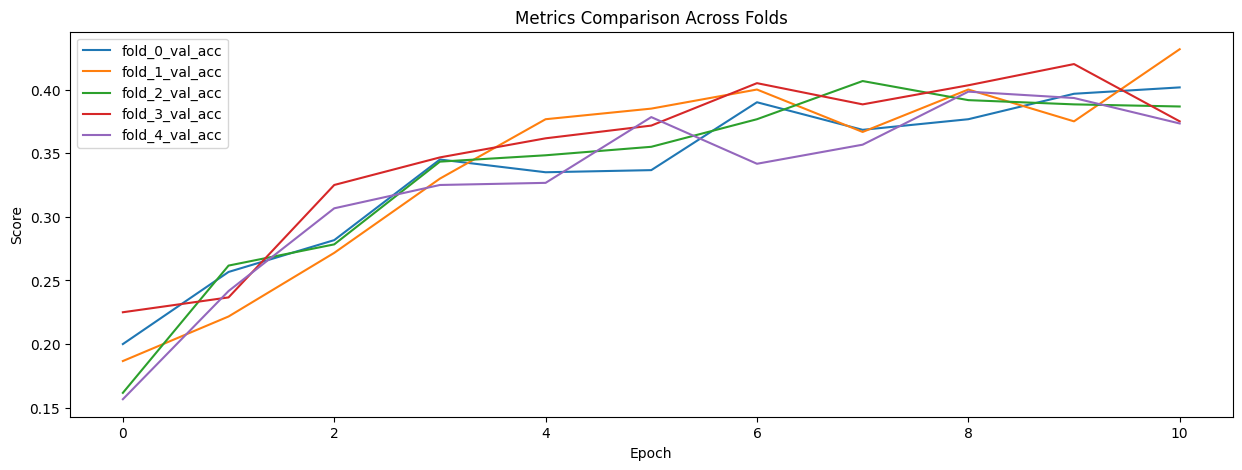

In [22]:
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))

metrics_df = pd.DataFrame()

# Concatenate data for all folds
for fold in range(5):
    df = pd.read_csv(f"logs_f{fold}/lightning_logs/{csv_logger_version}/metrics.csv")
    df['fold'] = fold
    del df["step"]
    metrics_df = pd.concat([metrics_df, df], ignore_index=True)
# Plot using matplotlib in one graph for each column score
for column in ['val_acc']:
    if column != 'epoch' and column != 'fold':
        for fold in range(5):
            data = metrics_df.query(f"fold == @fold")
            y = data[column].dropna()
            plt.plot(range(len(y)), y, label=f"fold_{fold}_{column}")

plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.title("Metrics Comparison Across Folds")
plt.show()

